In [100]:
import numpy as np
import torch as tr
import torch.nn as nn
from torch import distributions
from torch.nn.parameter import Parameter
import phi4_mg as m
import phi4 as p
import integrators as i
import update as u

import time
import matplotlib.pyplot as plt
from tqdm import tqdm

import argparse
import sys
    
import time
from stacked_model import *


In [101]:
class NonLinearRGlayer(nn.Module):
    def __init__(self, channels=1, hidden_channels=8, batch_size=1):
        super(NonLinearRGlayer, self).__init__()
        self.batch_size = batch_size

        # Nonlinear restrictor network: maps fine -> coarse
        self.restrict_net = nn.Sequential(
            nn.Conv2d(in_channels=channels, out_channels=hidden_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_channels, out_channels=channels, kernel_size=2, stride=2)  # downsampling
        )

        # Nonlinear prolongator network: maps coarse -> fine
        self.prolong_net = nn.Sequential(
            nn.ConvTranspose2d(in_channels=channels, out_channels=hidden_channels, kernel_size=2, stride=2),  # upsampling
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_channels, out_channels=channels, kernel_size=3, padding=1)
        )

    def coarsen(self, f):
        ff = f.view(f.shape[0], 1, f.shape[1], f.shape[2])  # B x 1 x H x W
        c = self.restrict_net(ff)
        r = ff - self.prolong_net(c)
        if self.batch_size == 1:
            return c.squeeze(1), r.squeeze(1)
        else:
            return c.squeeze(), r.squeeze()

    def refine(self, c, r):
        cc = c.view(c.shape[0], 1, c.shape[1], c.shape[2])
        rr = r.view(r.shape[0], 1, r.shape[1], r.shape[2])
        f_rec = self.prolong_net(cc) + rr
        if self.batch_size == 1:
            return f_rec.squeeze(1)
        else:
            return f_rec.squeeze()
    

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl

import os
os.environ["PATH"] = "/sciclone/home/yacahuanamedra/texlive/bin/x86_64-linux:" + os.environ["PATH"]

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
from matplotlib import rc
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{amsfonts}')
import pickle


from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 30}

mpl.rc('font', **font)

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 30}

mpl.rc('font', **font)

## Discrete action

\begin{equation}
S[\phi] = \sum_{x} \left[ 
    \frac{1}{2} \tilde{m} \, \phi(x)^2 
    + \frac{\lambda}{24} \, \phi(x)^4 
    - \sum_{\mu=1}^{N_d} \phi(x) \, \phi(x + \hat{\mu}) 
\right]
\end{equation}

## Generalize phi4 to any d

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Dec  10 9:38:24 2019

@author: Kostas Orginos
I have just modified it to work on arbitrary dimensions and do checks

"""

import numpy as np
import torch as tr

class phi4():
    def action(self,phi):
        #A = 0.5*self.mtil*tr.einsum('bxy,bxy->b',phi,phi) + (self.lam/24.0)*tr.einsum('bxy,bxy->b',phi**2,phi**2)
        #for mu in range(1,self.Nd+1):
        #    A = A - tr.einsum('bxy,bxy->b',phi,tr.roll(phi,shifts=-1,dims=mu))

        phi2 = phi*phi
        #A = tr.sum((0.5*self.mtil + (self.lam/24.0)*phi2)*phi2,dim=(1,2))
        #for mu in range(1,self.Nd+1):
        #    A = A - tr.sum(phi*tr.roll(phi,shifts=-1,dims=mu),dim=(1,2))

            
        A = tr.sum((0.5*self.mtil + (self.lam/24.0)*phi2)*phi2, dim=tuple(range(1, self.Nd+1)))
        for mu in range(1, self.Nd+1):
            A = A - tr.sum(phi * tr.roll(phi, shifts=-1, dims=mu), dim=tuple(range(1, self.Nd+1)))
        return A
    
    def force(self,phi):
        F = -self.mtil*phi - self.lam*phi**3/6.0
        for mu in range(1,self.Nd+1):
            F +=  tr.roll(phi,shifts= 1,dims=mu)+tr.roll(phi,shifts=-1,dims=mu)
        return F


    def refreshP(self):
        shape = [self.Bs] + list(self.V)
        P = tr.normal(0.0,1.0,shape,dtype=self.dtype,device=self.device)
        return P

    def evolveQ(self,dt,P,Q):
        return Q + dt*P
    
    def kinetic(self,P):
        spatial_dims = ''.join(chr(ord('a') + i) for i in range(self.Nd))#abcd for d=4
        einsum_str = f"z{spatial_dims},z{spatial_dims}->z"
        return tr.einsum(einsum_str,P,P)/2.0

    def hotStart(self):
        shape = [self.Bs] + list(self.V)
        sigma = tr.normal(0.0, 1.0, shape, dtype=self.dtype, device=self.device)
        return sigma
    
    def __init__(self,V,l,m,batch_size=1,device="cpu",dtype=tr.float32): 
            self.V = tuple(V) # lattice size
            self.Vol = np.prod(V)
            self.Nd = len(V)
            self.lam = l # the coupling
            self.mass  = m
            self.mtil = m + 2*self.Nd
            self.Bs=batch_size
            self.device=device
            self.dtype=dtype



def main():
    import time
    import matplotlib.pyplot as plt
    
    device = "cuda" if tr.cuda.is_available() else "cpu"
    print(f"Using {device} device")
    L=32
    batch_size=1
    lam =0.1
    mass= 0.1
    o = phi4([L],lam,mass,batch_size=batch_size, device=device, dtype=tr.float32)

    phi=o.hotStart()
    #plt.imshow(phi[0,:,:,1,2].detach().cpu().numpy(), cmap='hot', interpolation='nearest')
    #plt.show()
    print(f"phi shape {phi.shape} dtype {phi.dtype} device {phi.device}")
    tic=time.perf_counter()
    Niter=10000
    for k in range(Niter):
        o.action(phi)
    toc=time.perf_counter()
    print(f"action time {(toc - tic)*1.0e6/Niter:0.4f} micro-seconds")

    tic=time.perf_counter()
    for k in range(Niter):
        o.force(phi)
    toc=time.perf_counter()
    print(f"force time {(toc - tic)*1.0e6/Niter:0.4f} micro-seconds")    

    P = o.refreshP()

    tic=time.perf_counter()
    for k in range(Niter):
        o.kinetic(phi)
    toc=time.perf_counter()
    print(f"kinetic time {(toc - tic)*1.0e6/Niter:0.4f} micro-seconds")    

if __name__ == "__main__":
   main()

Using cuda device
phi shape torch.Size([1, 32]) dtype torch.float32 device cuda:0
action time 79.4677 micro-seconds
force time 74.4008 micro-seconds
kinetic time 35.9149 micro-seconds


## Some observables

Phase in the code $\delta_n=e^{\frac{2i\pi}{L}n}$ with $p_n=\frac{2\pi}{L}n$

\begin{align}
\text{Field average or magnetization:} \quad
\langle \phi \rangle &= \frac{1}{V} \sum_x \phi(x) \\[8pt]
\text{Magnetic susceptibility:} \quad
\chi_m &= V \cdot \langle \phi \rangle^2 \\[8pt]
\text{Two-point correlator at momentum $p$}: \quad
C_2(p) &= V \cdot \left| \frac{1}{V} \sum_x \phi(x) \, e^{i p_n x} \right|^2 \\[8pt]
\text{Energy density:} \quad
E &= \frac{S[\phi]}{V}
\end{align}

In [2]:
#!/usr/local/bin/python3
import time
import numpy as np
import torch as tr
import phi4 as s
import integrators as i
import update as u

import matplotlib.pyplot as plt

device = "cuda" if tr.cuda.is_available() else "cpu"
if(device=="cpu"):
    device = "mps" if tr.backends.mps.is_available() else "cpu"
# OK I will always use CPU for now
device = "cpu"
device = tr.device(device)
print(f"Using {device} device")

    
def jackknife(d):
    # d is the list containing data
    # NOTE: it works with python lists not numpy arrays
    #
    N=len(d) -1 
    ss = sum(d)
    r=[]
    for n in range(len(d)):
        r.append((ss-d[n])/N)

    return r

def average(d):
    m = np.mean(d)
    e = np.std(d)/np.sqrt(len(d)-1)
    return m,e

def correlation_length(L,ChiM,C2p):
     return 1/(2*np.sin(np.pi/L))*np.sqrt(ChiM/C2p -1)

Using cpu device


In [ ]:
def get_observables_hist(sg,rg, hmc, phi, Nwarm, Nmeas, Nskip):

    tic=time.perf_counter()
    Vol=sg.Vol
    lat=[phi.shape[1], phi.shape[2]]
    toc=time.perf_counter()

    print(f"time {(toc - tic)*1.0e6/Nwarm:0.4f} micro-seconds per HMC trajecrory")

    lC2p = []
    lchi_m = []
    E = []
    av_phi = []
    phase=tr.tensor(np.exp(1j*np.indices(tuple(lat))[0]*2*np.pi/lat[0]))
    for k in range(Nmeas):
        ttE = sg.action(phi)/Vol
        E.extend(ttE)
        av_sigma = tr.mean(phi.view(sg.Bs,Vol),axis=1)
        av_phi.extend(av_sigma)
        chi_m = av_sigma*av_sigma*Vol
        p1_av_sig = tr.mean(phi.view(sg.Bs,Vol)*phase.view(1,Vol),axis=1)
        C2p = tr.real(tr.conj(p1_av_sig)*p1_av_sig)*Vol
        if(k%10==0):
            print("k= ",k,"(av_phi,chi_m, c2p, E) ", av_sigma.mean().numpy(),chi_m.mean().numpy(),C2p.mean().numpy(),ttE.mean().numpy())
        lC2p.extend(C2p)
        lchi_m.extend(chi_m)
        ## HMC update but also V cycle
        phi = hmc.evolve(phi,Nskip)

    return lC2p, lchi_m, E, av_phi, phi

def get_observables(lC2p, lchi_m, E, av_phi, phi):

    Vol=phi.shape[1]*phi.shape[2]
    lat=[phi.shape[1], phi.shape[2]]
    
    m_phi, e_phi = average(av_phi)
    print("m_phi: ",m_phi,e_phi)

    m_chi_m, e_chi_m = average(np.array(lchi_m) - (m_phi**2)*Vol)
    m_C2p, e_C2p     = average(lC2p)
    print(r"$\chi_m$: ",m_chi_m,'+/-', e_chi_m)
    print("C2p  : ",m_C2p,'+/-', e_C2p)
    avE,eE = average(E)
    print("E = ", avE ,'+/-',eE)

    xi = correlation_length(lat[0],m_chi_m, m_C2p)
    print("The correlation length is: ",xi)
    jphi   = np.array(jackknife(av_phi))
    jchi_m = np.array(jackknife(lchi_m)) - jphi**2 * Vol
    jC2p   = np.array(jackknife(lC2p))


    j_xi = correlation_length(lat[0],jchi_m,jC2p)

    m_xi,e_xi = average(j_xi)

    return m_phi, e_phi,m_chi_m, e_chi_m,m_C2p, e_C2p,avE,eE,xi,m_xi,e_xi,phi


def autocorrelation1(trace):
    #divide trace in 2
    trace=trace[0:trace.shape[0]]
    n=trace.shape[0]
    mean=tr.mean(trace)
    var=tr.var(trace)
    autocorr=tr.zeros_like(trace)
    for k in range(0,n-1):
        autocorr[k]=tr.sum((trace[0:n-k]-mean)*(trace[k:n]-mean))/(var*(n-k))
    return autocorr


def autocorrelation(trace):
    x = tr.as_tensor(trace, dtype=tr.float64)
    n = x.shape[0]
    x = x - x.mean()
    var = x.var(unbiased=False)
    acf = tr.zeros(n, dtype=x.dtype)
    for k in range(n):
        acf[k] = tr.dot(x[:n-k], x[k:]) / (var * (n - k))
    return acf # acf[0] == 1

#τ_int (Sokal: τ_int = 0.5 + sum_{t=1}^W ρ_t)
def integrated_autocorrelation_time(acf, max_lag=None):
    x = tr.as_tensor(acf, dtype=tr.float64)
    if x[0].abs().item() > 0:
        x = x / x[0]
    n = x.shape[0]
    if max_lag is None:
        W = 0
        for t in range(1, n):
            if (x[t] <= 0).item():
                break
            W = t
    else:
        W = min(int(max_lag), n - 1)
    return float(0.5 + x[1:W+1].sum().item())

def integrated_autocorrelation_time1(acf, max_lag=None):
    if max_lag is None:
        for t in range(1, len(acf)):
            if acf[t] < 0:
                max_lag = t
                break
        else:
            max_lag = len(acf) - 1
    return 0.5 + tr.sum(acf[1:max_lag])
def get_autocorrelationtime(av_phi, lchi_m):
    acf_phi = autocorrelation(tr.tensor(av_phi))
    #acf_phi = acf_phi / acf_phi[0]
    acf_suscept = autocorrelation(tr.tensor(lchi_m))
    max_lag=len(av_phi)//4
    print(acf_phi.shape)
    tau_int_phi = integrated_autocorrelation_time(acf_phi,max_lag)
    tau_int_suscept = integrated_autocorrelation_time(acf_suscept,max_lag)
    return tau_int_phi, tau_int_suscept

In [68]:

import integrators as i

mass_grid=np.linspace(-.58,-0.55,11)
L=128
lat = [L,L]
# This set of params is very very close to critical.
lam = 2.4
mas = -0.3
#
Nwarm = 1000
Nmeas = 3000
Nskip = 1
batch_size = 1

Vol = np.prod(lat)
sg = s.phi4(lat,lam,mas,batch_size=batch_size,device=device)
phi = sg.hotStart()
mn2 = i.minnorm2(sg.force,sg.evolveQ,7,1.0)
print(phi.shape,Vol,tr.mean(phi),tr.std(phi))
hmc = u.hmc(T=sg,I=mn2,verbose=False)

lC2p, lchi_m, E, av_phi, phi = get_observables_hist(sg, hmc, phi, Nwarm, Nmeas, Nskip)
tau_phi,tau_chi = get_autocorrelationtime(av_phi, lchi_m)
m_phi, e_phi,m_chi_m, e_chi_m,m_C2p, e_C2p,avE,eE,xi,m_xi,e_xi,phi=get_observables(lC2p, lchi_m, E, av_phi, phi)

torch.Size([1, 128, 128]) 16384 tensor(0.0078) tensor(1.0012)
time 0.0032 micro-seconds per HMC trajecrory
k=  0 (av_phi,chi_m, c2p, E)  0.0077968156 0.99598885 0.4768859725538614 2.1466208
k=  10 (av_phi,chi_m, c2p, E)  0.0077968156 0.99598885 0.4768859725538614 2.1466208
k=  20 (av_phi,chi_m, c2p, E)  0.0077968156 0.99598885 0.4768859725538614 2.1466208
k=  30 (av_phi,chi_m, c2p, E)  0.0077968156 0.99598885 0.4768859725538614 2.1466208
k=  40 (av_phi,chi_m, c2p, E)  0.0077968156 0.99598885 0.4768859725538614 2.1466208
k=  50 (av_phi,chi_m, c2p, E)  0.007255488 0.86248827 2.9476458496911104 0.57944787
k=  60 (av_phi,chi_m, c2p, E)  0.02115745 7.3340955 13.16270161517827 0.4791369
k=  70 (av_phi,chi_m, c2p, E)  0.015583775 3.9789207 4.538043963719321 0.47576794
k=  80 (av_phi,chi_m, c2p, E)  0.028742027 13.534889 0.19843599281335203 0.4593983
k=  90 (av_phi,chi_m, c2p, E)  -0.0056289462 0.5191276 1.0603901289337723 0.46185446
k=  100 (av_phi,chi_m, c2p, E)  -0.029483208 14.241949 21.96

In [92]:
tr.tensor(hmc.AcceptReject).sum()/len(hmc.AcceptReject)

tensor(0.9837)

In [ ]:

mass_grid1=np.linspace(-.585,-0.54,11)
tau_phi1=np.zeros_like(mass_grid1)
tau_suscept1=np.zeros_like(mass_grid1)
sss=0
for mas in mass_grid1:
    L=128
    lat = [L,L]
    # This set of params is very very close to critical.
    lam = 2.4
    #
    Nwarm = 1000
    Nmeas = 10000
    Nskip = 1
    batch_size = 1

    Vol = np.prod(lat)
    sg = s.phi4(lat,lam,mas,batch_size=batch_size,device=device)
    phi = sg.hotStart()
    mn2 = i.minnorm2(sg.force,sg.evolveQ,7,1.0)
    print(phi.shape,Vol,tr.mean(phi),tr.std(phi))
    hmc = u.hmc(T=sg,I=mn2,verbose=False)

    lC2p, lchi_m, E, av_phi, phi = get_observables_hist(sg, hmc, phi, Nwarm, Nmeas, Nskip)
    tau_phi1[sss],tau_suscept1[sss] = get_autocorrelationtime(av_phi, lchi_m)
    sss+=1
    m_phi, e_phi,m_chi_m, e_chi_m,m_C2p, e_C2p,avE,eE,xi,m_xi,e_xi,phi=get_observables(lC2p, lchi_m, E, av_phi, phi)

torch.Size([1, 128, 128]) 16384 tensor(0.0065) tensor(1.0014)
time 0.0024 micro-seconds per HMC trajecrory
k=  0 (av_phi,chi_m, c2p, E)  0.0064823795 0.6884761 0.8640319804070171 2.0135882
k=  10 (av_phi,chi_m, c2p, E)  0.0064823795 0.6884761 0.8640319804070171 2.0135882
k=  20 (av_phi,chi_m, c2p, E)  0.0064823795 0.6884761 0.8640319804070171 2.0135882
k=  30 (av_phi,chi_m, c2p, E)  0.003357045 0.1846436 22.25547364005394 0.5883843
k=  40 (av_phi,chi_m, c2p, E)  0.0107970685 1.9099925 53.658887217465505 0.4364301
k=  50 (av_phi,chi_m, c2p, E)  0.02215197 8.039788 59.839243126688515 0.41428712
k=  60 (av_phi,chi_m, c2p, E)  0.024900757 10.158861 82.91823801376114 0.3951214
k=  70 (av_phi,chi_m, c2p, E)  0.024591262 9.907899 161.06258640709422 0.39708683
k=  80 (av_phi,chi_m, c2p, E)  -0.012084626 2.3926895 263.91612154000444 0.40127695
k=  90 (av_phi,chi_m, c2p, E)  -0.015516929 3.9448593 134.88048236555136 0.3916137
k=  100 (av_phi,chi_m, c2p, E)  -0.020551186 6.9198027 66.586343877864

/var/folders/94/dxw8_0ks7t911nx4g989q6180000gn/T/ipykernel_91931/3696463069.py:38: RuntimeWarning: invalid value encountered in sqrt
  return 1/(2*np.sin(np.pi/L))*np.sqrt(ChiM/C2p -1)


torch.Size([1, 128, 128]) 16384 tensor(-0.0082) tensor(1.0002)
time 0.0010 micro-seconds per HMC trajecrory
k=  0 (av_phi,chi_m, c2p, E)  -0.008166616 1.0927082 2.076959528063591 1.9931512
k=  10 (av_phi,chi_m, c2p, E)  0.017057363 4.7669845 3.493880132394148 0.5298067
k=  20 (av_phi,chi_m, c2p, E)  -0.00487567 0.38948306 0.9247983295072499 0.4350913
k=  30 (av_phi,chi_m, c2p, E)  -0.043268703 30.673807 7.6190210853830775 0.4182393
k=  40 (av_phi,chi_m, c2p, E)  -0.03496287 20.02784 16.799950338381986 0.41294783
k=  50 (av_phi,chi_m, c2p, E)  -0.037929974 23.571383 22.402237227561933 0.3933331
k=  60 (av_phi,chi_m, c2p, E)  0.0019467343 0.062091663 0.878375447896741 0.39483228
k=  70 (av_phi,chi_m, c2p, E)  -0.030542288 15.283509 1.3587878976503724 0.39892027
k=  80 (av_phi,chi_m, c2p, E)  -0.023267128 8.86963 18.181838612344276 0.39948446
k=  90 (av_phi,chi_m, c2p, E)  -0.013786667 3.1141427 18.125821193294605 0.39438665
k=  100 (av_phi,chi_m, c2p, E)  0.011533686 2.1794965 5.85263508

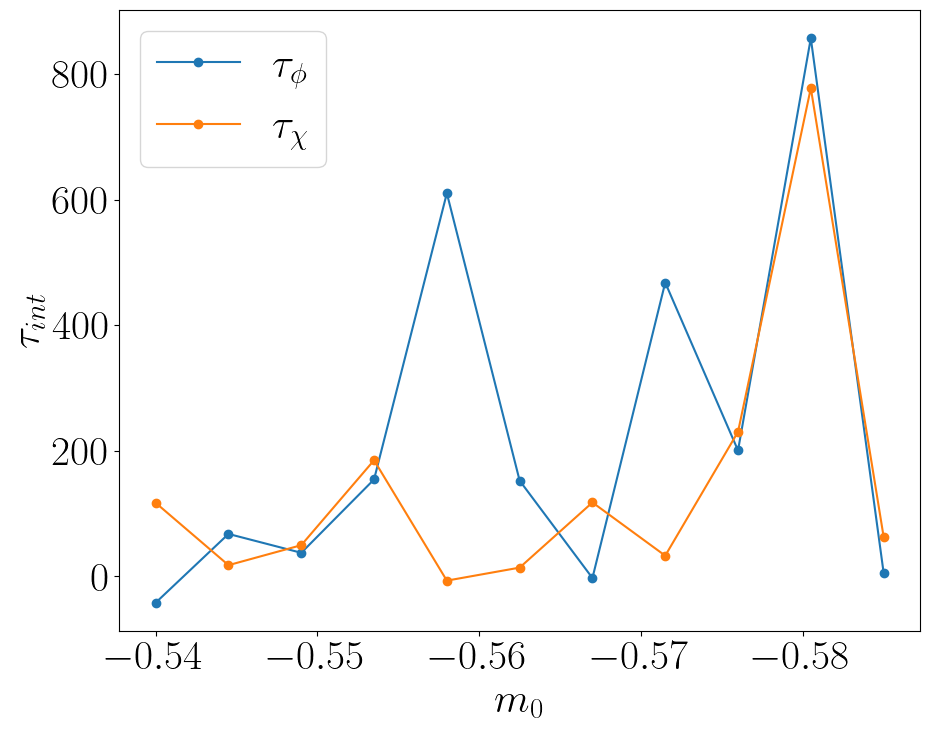

In [91]:
#plot mass vs tau
plt.figure(figsize=(10,8))
#reverse mass axis
plt.gca().invert_xaxis()
plt.plot(mass_grid1,tau_phi,'o-',label=r'$\tau_{\phi}$')
plt.plot(mass_grid1,tau_suscept,'o-',label=r'$\tau_{\chi}$')
plt.xlabel(r'$m_0$', fontsize=30)
plt.ylabel(r'$\tau_{int}$', fontsize=30)
#plt.yscale('log')
plt.legend(fontsize=30)

### Relations of meassurements

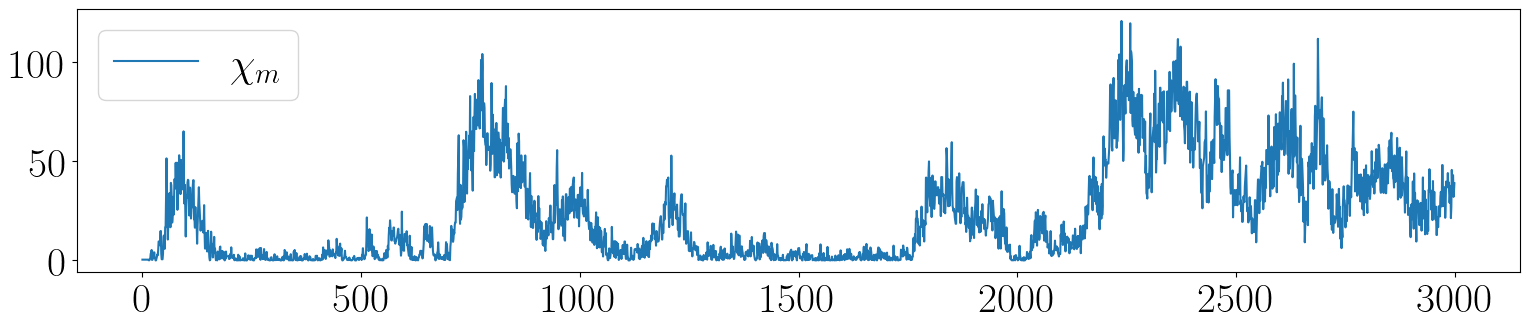

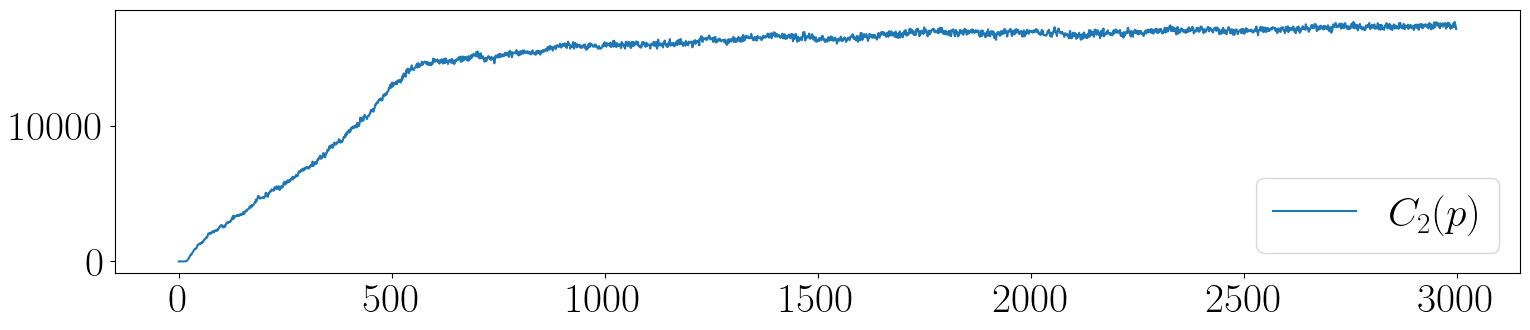

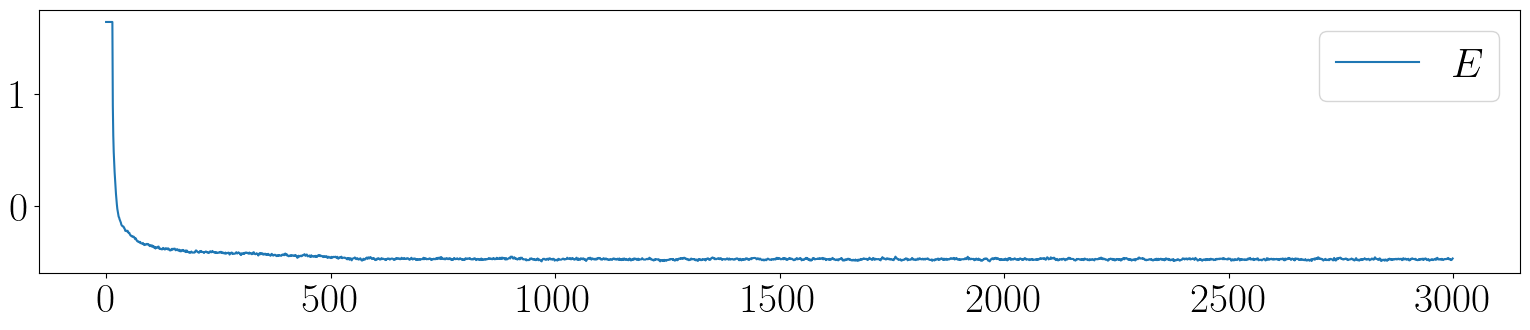

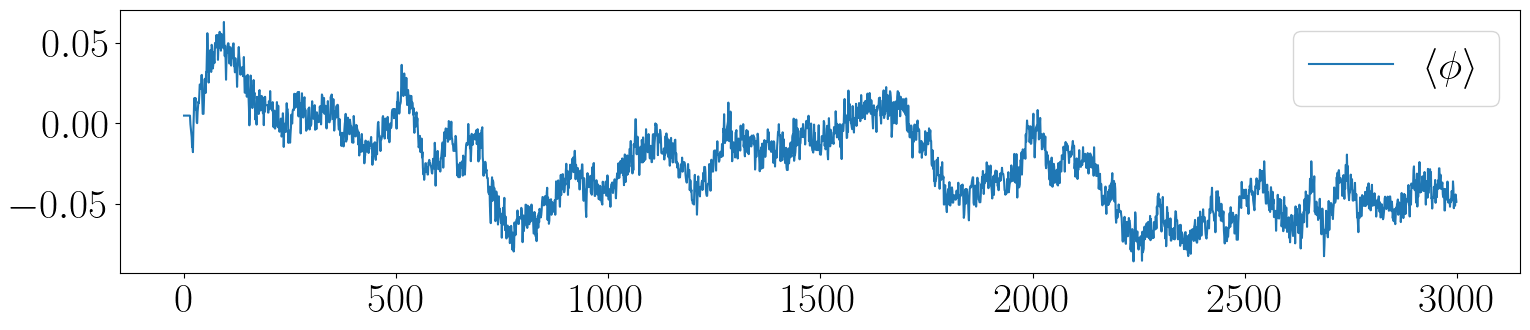

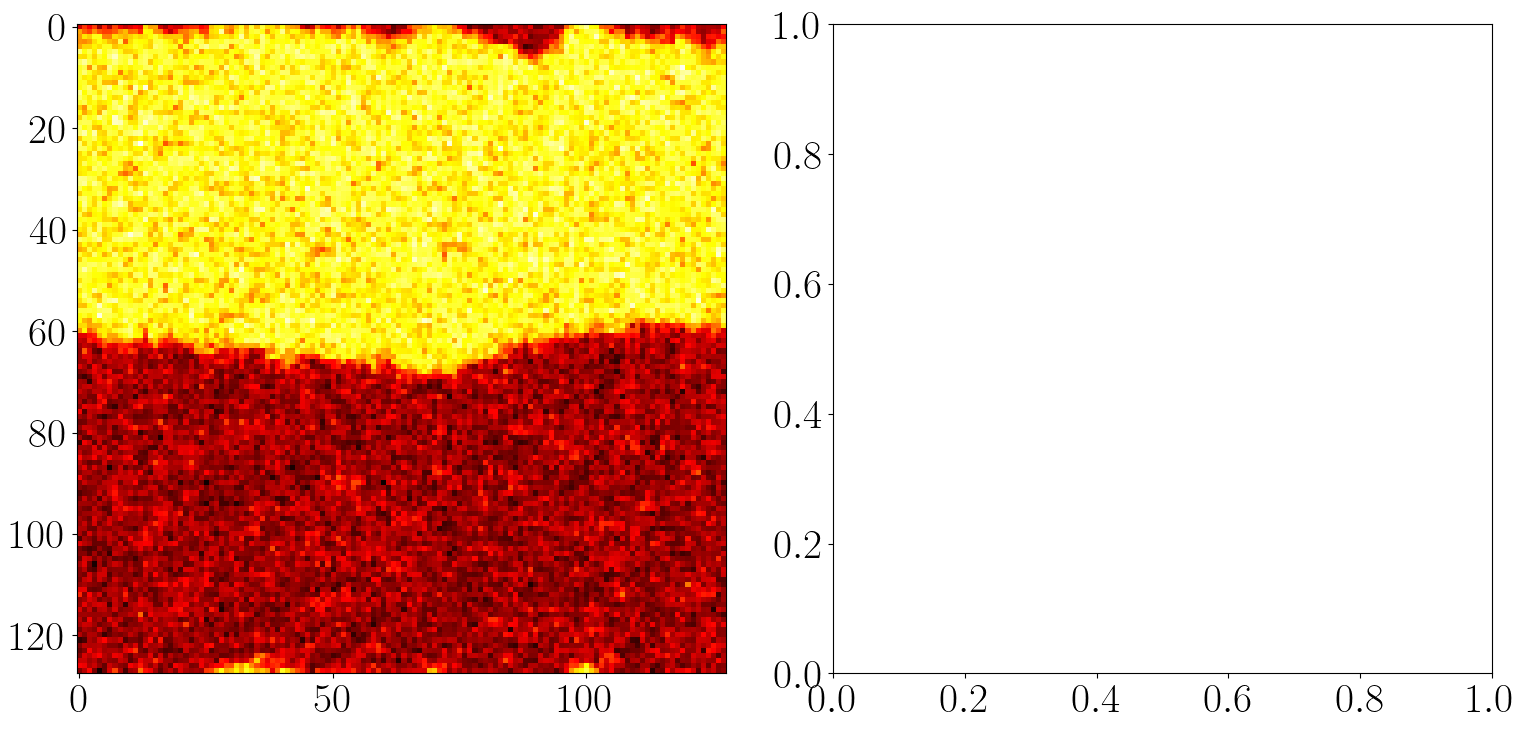

In [50]:

#size of the plot
plt.figure(figsize=(16, 4))
plt.plot(range(len(lchi_m)),lchi_m, label=r'$\chi_m$')
plt.legend()
plt.show()
plt.figure(figsize=(16, 4))
plt.plot(range(len(lC2p)),lC2p, label=r'$C_2(p)$')
plt.legend()
plt.show()
plt.figure(figsize=(16, 4))
plt.plot(range(len(E)),E, label=r'$E$')
plt.legend()
plt.show()
plt.figure(figsize=(16, 4))
plt.plot(range(len(av_phi)),av_phi, label=r'$\langle\phi\rangle$')
plt.legend()
plt.show()

fig, ax = plt.subplots(1,2, figsize=(16, 8))
for i in range(1):
    ax[i].imshow(phi[i,:,:], cmap='hot', interpolation='nearest')


# Autocorrelation time
Given the formula for autocorrelation time
$$C_X(t) = \frac{1}{(N - t) \cdot \sigma^2} \sum_{i=0}^{N-t-1} (X_i - \bar{X})(X_{i+t} - \bar{X})?$$

torch.Size([3000])
Integrated autocorrelation time for M: 209.80585245698467
Integrated autocorrelation time for chi_m: 164.6775212782384


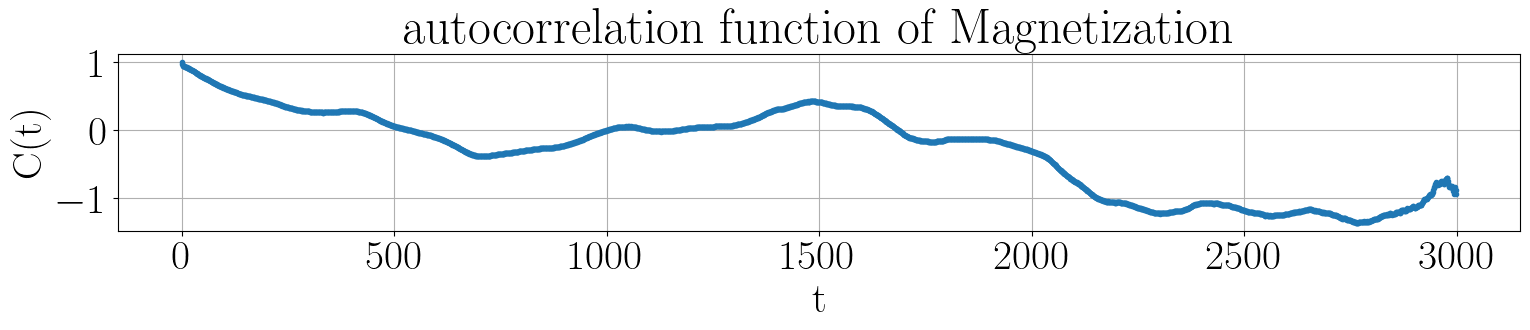

Text(0.5, 0, 't')

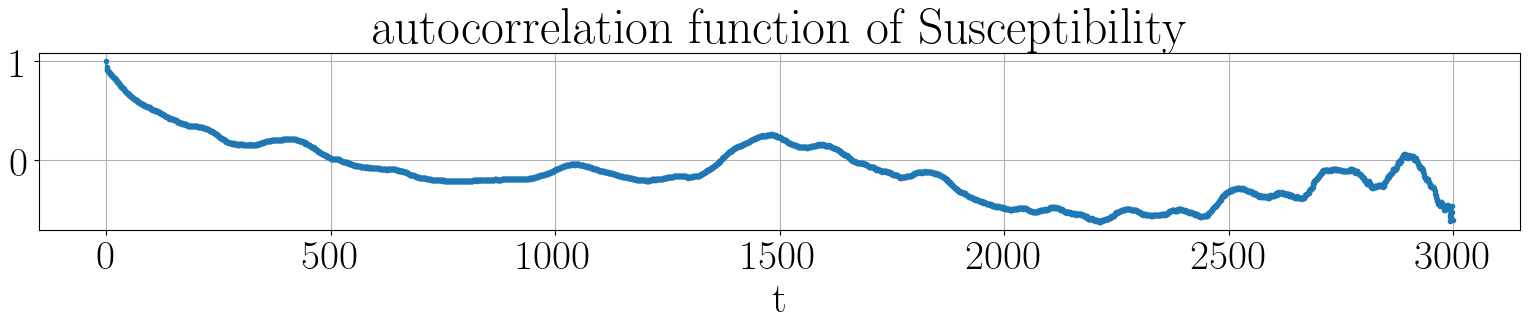

In [ ]:


acf_phi = autocorrelation(tr.tensor(av_phi))
#acf_phi = acf_phi / acf_phi[0]
acf_suscept = autocorrelation(tr.tensor(lchi_m))
print(acf_phi.shape)
tau_int_phi = integrated_autocorrelation_time(acf_phi,600)
tau_int_suscept = integrated_autocorrelation_time(acf_suscept,600)
print(f"Integrated autocorrelation time for M: {tau_int_phi}")
print(f"Integrated autocorrelation time for chi_m: {tau_int_suscept}")

plt.figure(figsize=(16, 4))
plt.plot(acf_phi[:5000], marker='.')
plt.title("autocorrelation function of Magnetization ")
plt.xlabel("t")
plt.ylabel("C(t)")
plt.grid(True)
plt.show()
plt.figure(figsize=(16, 4))
plt.plot(acf_suscept[:5000], marker='.')
plt.title("autocorrelation function of Susceptibility ")
plt.grid(True)
plt.xlabel("t")

# Multigrid

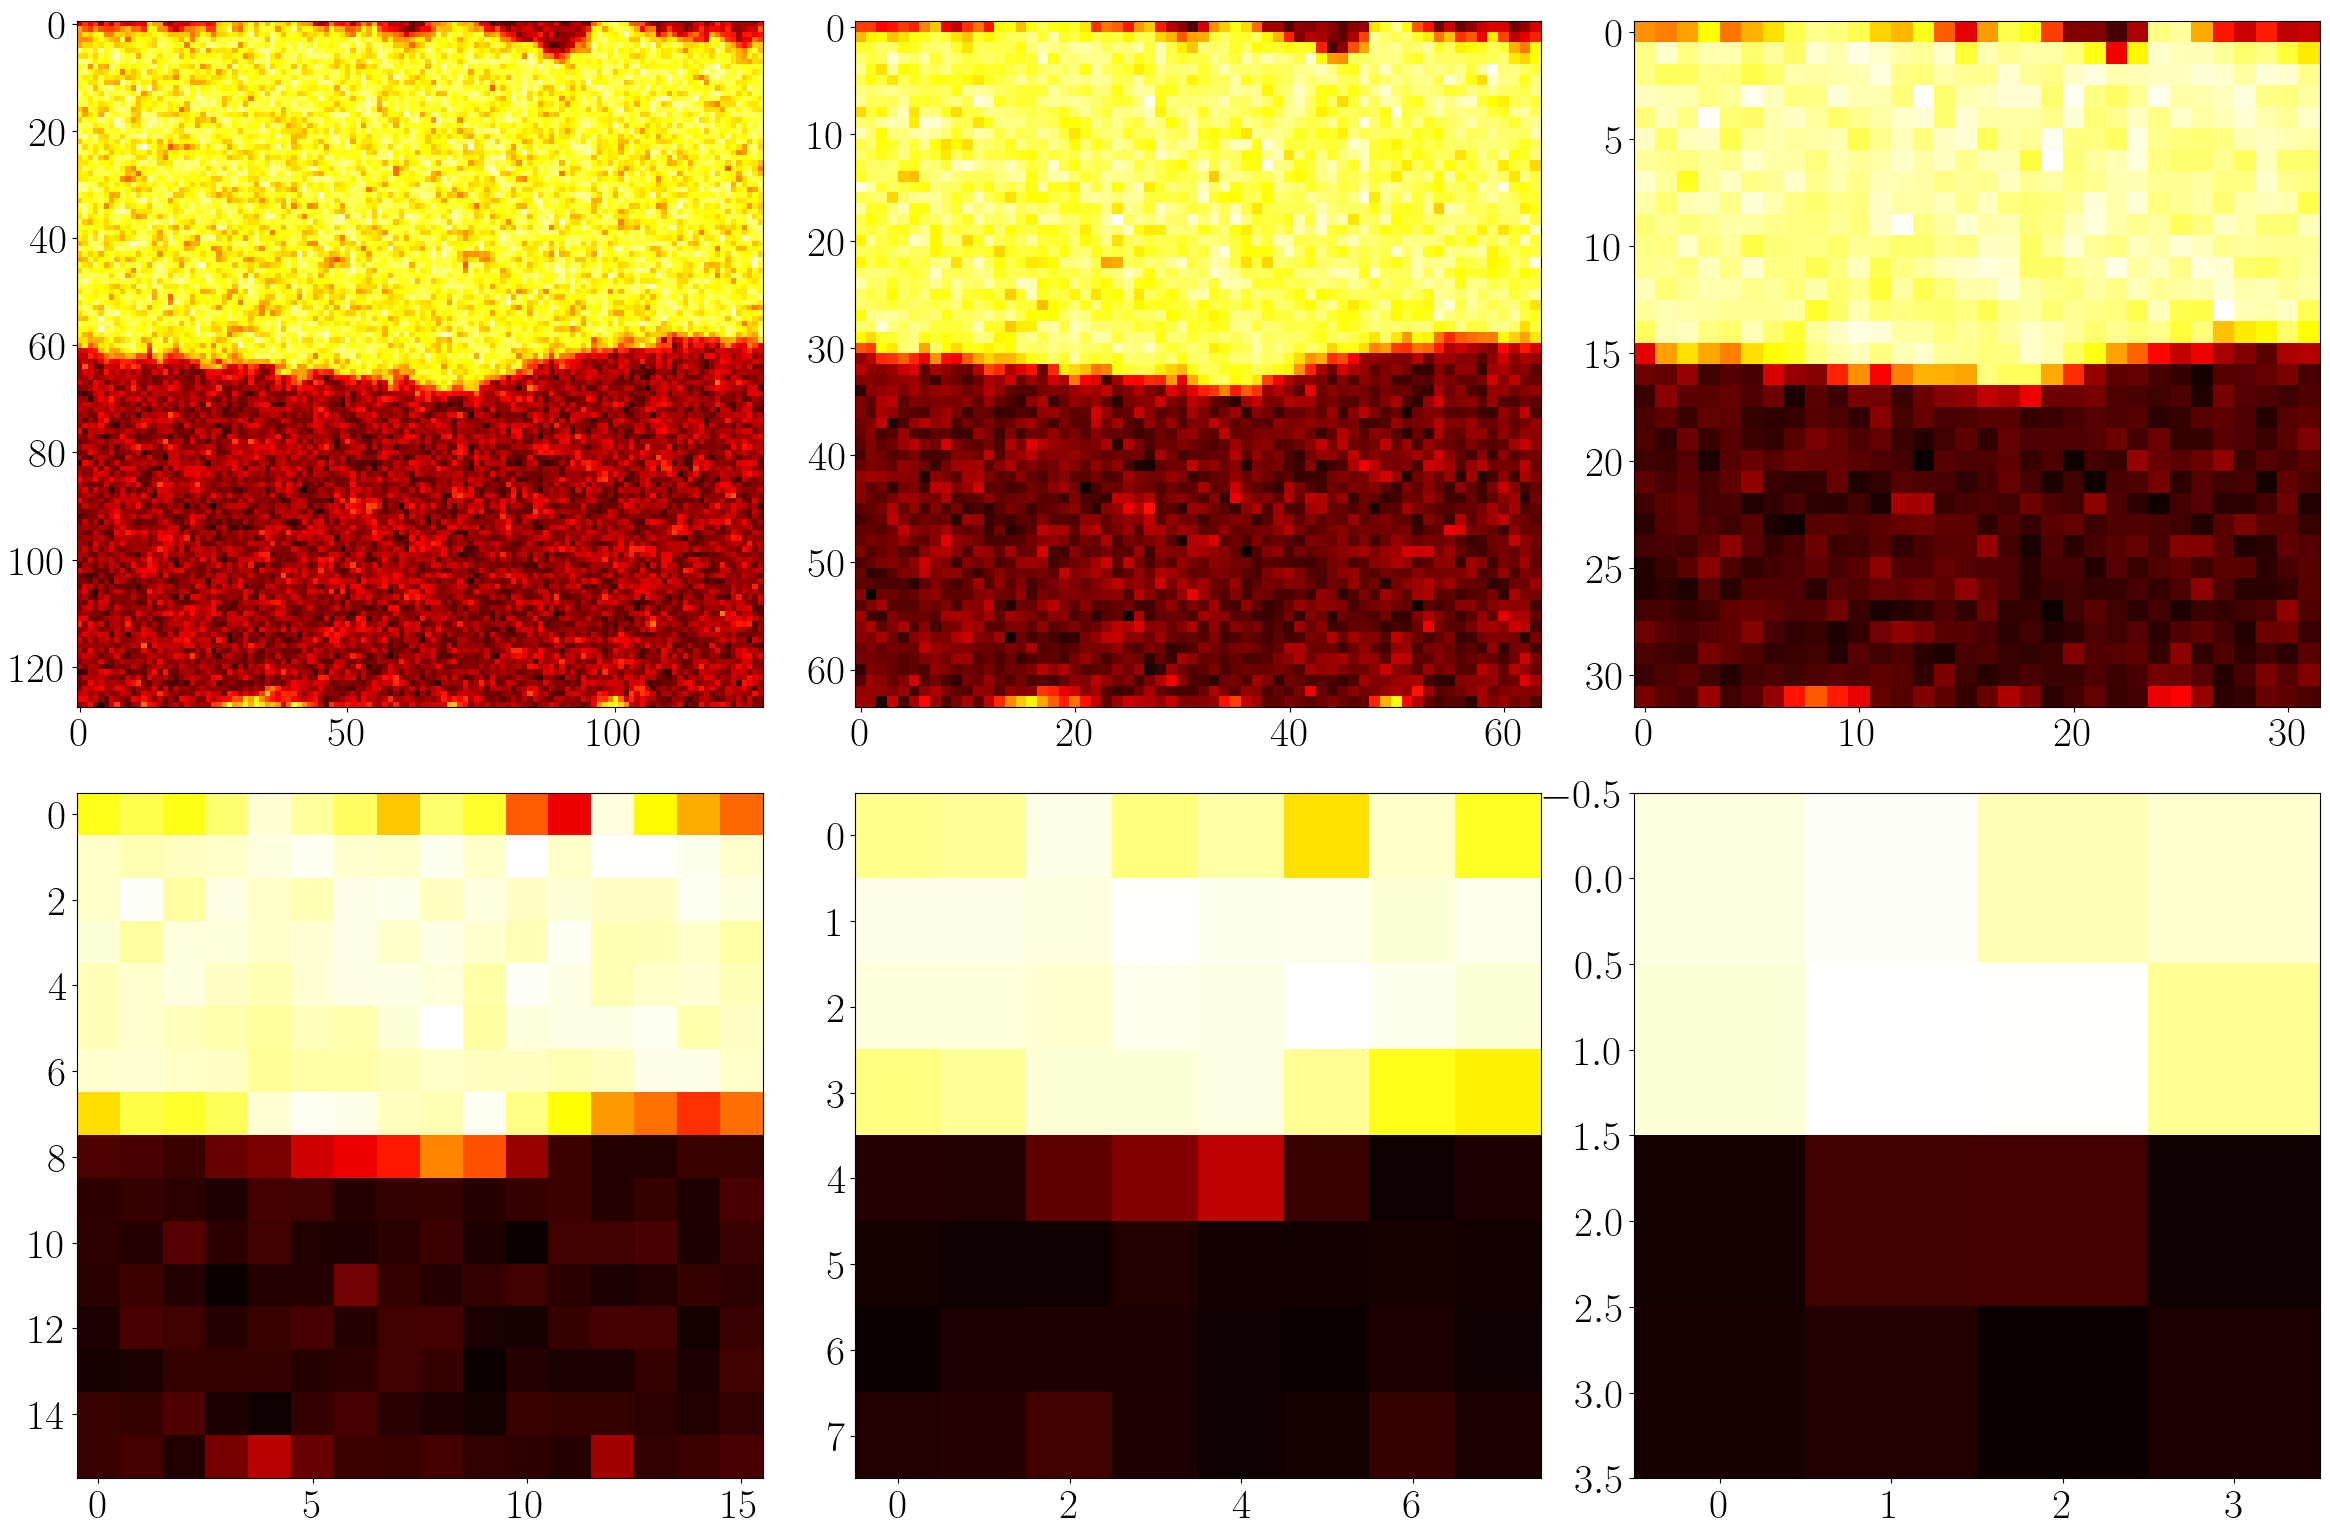

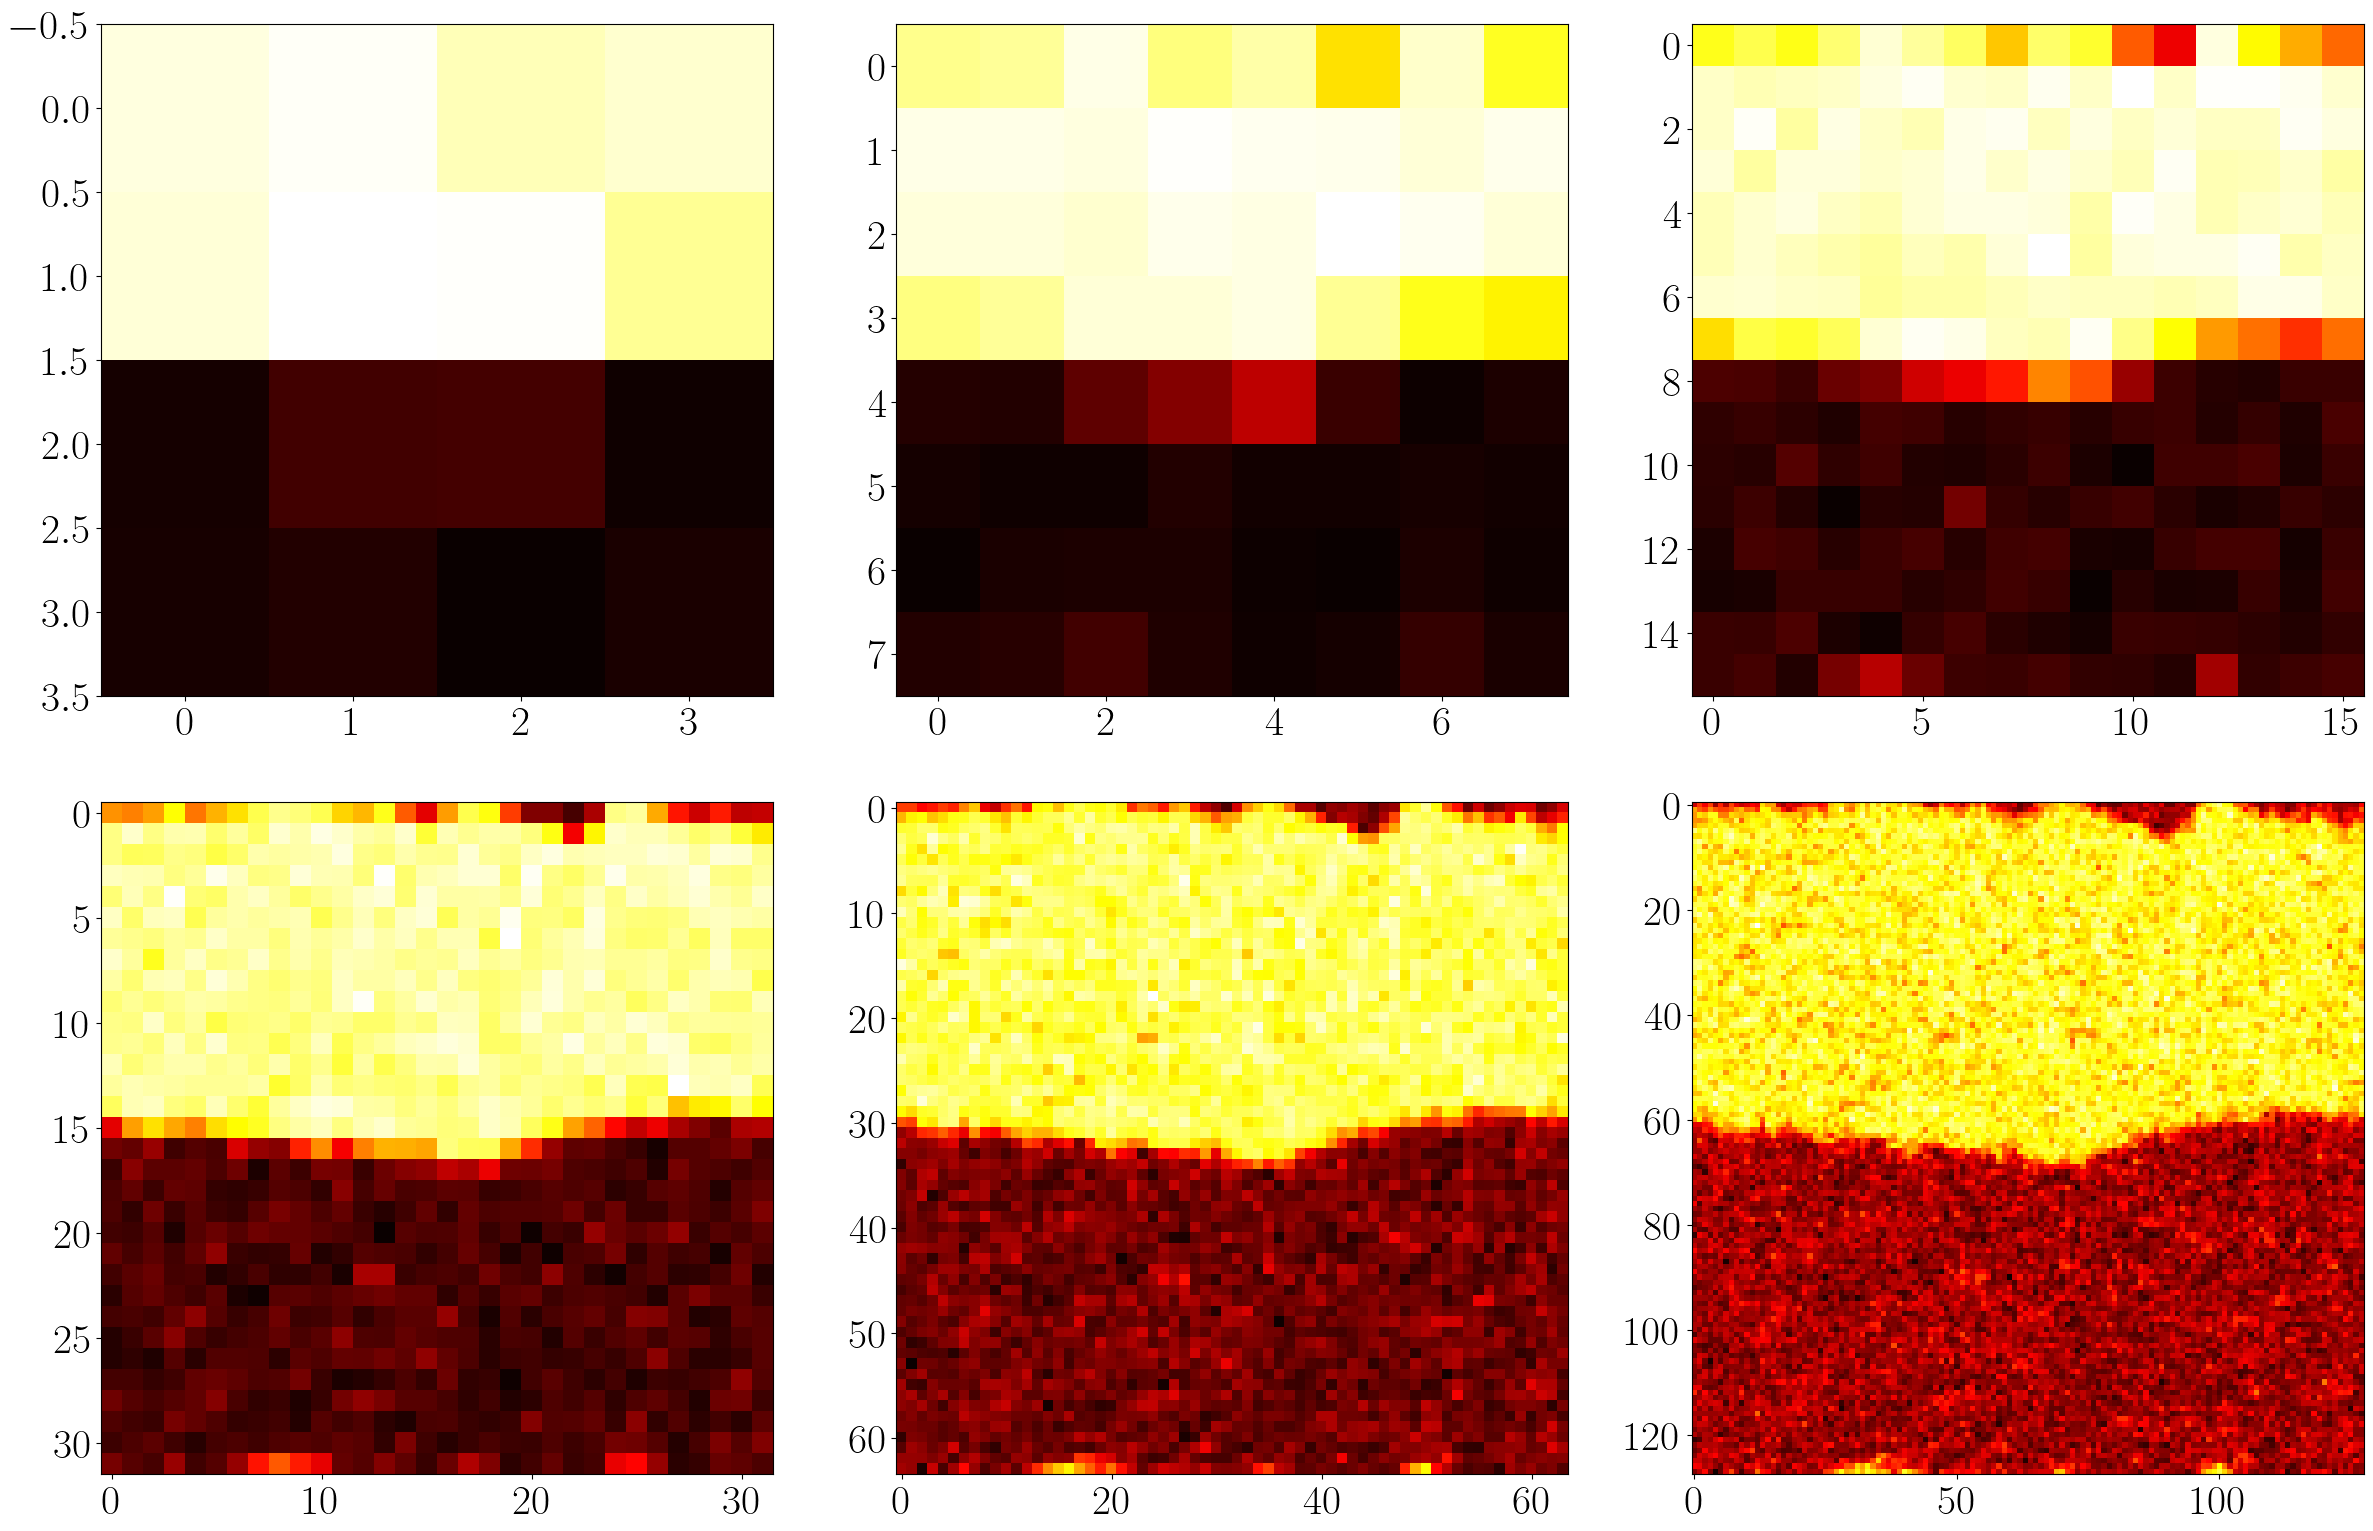

In [53]:
import phi4_mg as phimg
rg = phimg.RGlayer("average")
import integrators as i

phis=[]
pis=[]
phicopy=phi.clone()
phis.append(phi)
for _ in range(5):
    phic,pic = rg.coarsen(phicopy)
    phis.append(phic)
    pis.append(pic)
    phicopy=phic

#reversed
rphis=[]
rphis.append(phis[-1])
iii=0
for pics in reversed(pis):
    rphi = rg.refine(rphis[iii],pics)
    rphis.append(rphi)
    iii+=1

#plot the phi field
fig, ax = plt.subplots(2,3, figsize=(24, 16))
ax[0,0].imshow(phis[0][0,:,:], cmap='hot', interpolation='nearest')
ax[0,1].imshow(phis[1][0,:,:], cmap='hot', interpolation='nearest')
ax[0,2].imshow(phis[2][0,:,:], cmap='hot', interpolation='nearest')
ax[1,0].imshow(phis[3][0,:,:], cmap='hot', interpolation='nearest')
ax[1,1].imshow(phis[4][0,:,:], cmap='hot', interpolation='nearest')
ax[1,2].imshow(phis[5][0,:,:], cmap='hot', interpolation='nearest')
plt.show()
#one level up
fig, ax = plt.subplots(2,3, figsize=(24, 16))
ax[0,0].imshow(rphis[0][0,:,:], cmap='hot', interpolation='nearest')
ax[0,1].imshow(rphis[1][0,:,:], cmap='hot', interpolation='nearest')
ax[0,2].imshow(rphis[2][0,:,:], cmap='hot', interpolation='nearest')
ax[1,0].imshow(rphis[3][0,:,:], cmap='hot', interpolation='nearest')
ax[1,1].imshow(rphis[4][0,:,:], cmap='hot', interpolation='nearest')
ax[1,2].imshow(rphis[5][0,:,:], cmap='hot', interpolation='nearest')
#save figure
plt.savefig("rphis.pdf", bbox_inches='tight',dpi=300)
plt.show()
#one level down 

now we have to update the coarse field, and compare with any of the ml implementation in phi4_mg

In [82]:
class phi4_c1:
    def action(self,phi_c):
        rphis=[]
        rphis.append(phi_c)
        iii=0
        for pi in reversed(self.pics):
            #print(pi.shape)
            rphi = self.rg.refine(rphis[iii],pi)
            rphis.append(rphi)
            iii+=1
        phi_f = rphis[-1]
        #evaluate coarse field in action of rg
        #print(phi_f.shape,"shape of fine field")
        return self.sg.action(phi_f)
        #if I dont add the .sum() I got a grad for the batch system, it seems to me that we include that in the force property the batch is summed?

    def force(self, phi_c):
        x_tensor = phi_c.detach().clone().requires_grad_()

        S = -self.action(x_tensor)
        grad = tr.autograd.grad(S.sum(), x_tensor, retain_graph=True)[0]

        if grad is None:
            print("[ERROR] Gradiente es None.")
            raise RuntimeError("autograd.grad devolvió None")

        return grad
    
    def refreshP(self):
        P = tr.normal(0.0,1.0,self.phis[-1].shape)#only difference with fine level
        return P

    def evolveQ(self,dt,P,Q):
        return Q + dt*P
    
    def kinetic(self,P):
        return tr.einsum('bxy,bxy->b',P,P)/2.0

    def generate_cfg_levels(self,phi11,level):#run every time we need to contruct deeper or superficial levels
        #run a configuration
        self.level=level
        phis=[]
        pis=[]
        phicopy=phi11.clone()
        #print("shape of the original field",phicopy.shape)
        phis.append(phicopy)
        for _ in range(level):
            #print("coarsening level ",_," field shape ",phicopy.shape)
            phic,pic = self.rg.coarsen(phicopy)
            phis.append(phic)
            pis.append(pic)
            phicopy=phic
        self.phis=phis
        self.pics=pis

        #reversed
        rphis=[]
        rphis.append(phis[-1])
        for phics,pis in zip(reversed(phis),reversed(pis)):
            rphi = self.rg.refine(phics,pis)
            rphis.append(rphi)
        self.rphis=rphis

    def __init__(self,sgg,rgg):
        self.sg = sgg#theory? in the finest level
        self.rg = rgg#projector to coarse level



shape of the original field torch.Size([1, 128, 128])
coarsening level  0  field shape  torch.Size([1, 128, 128])
coarsening level  1  field shape  torch.Size([1, 64, 64])
refining level  torch.Size([1, 32, 32])
refining level  torch.Size([1, 64, 64])
reject rate:  [1.0]
tensor(1.)


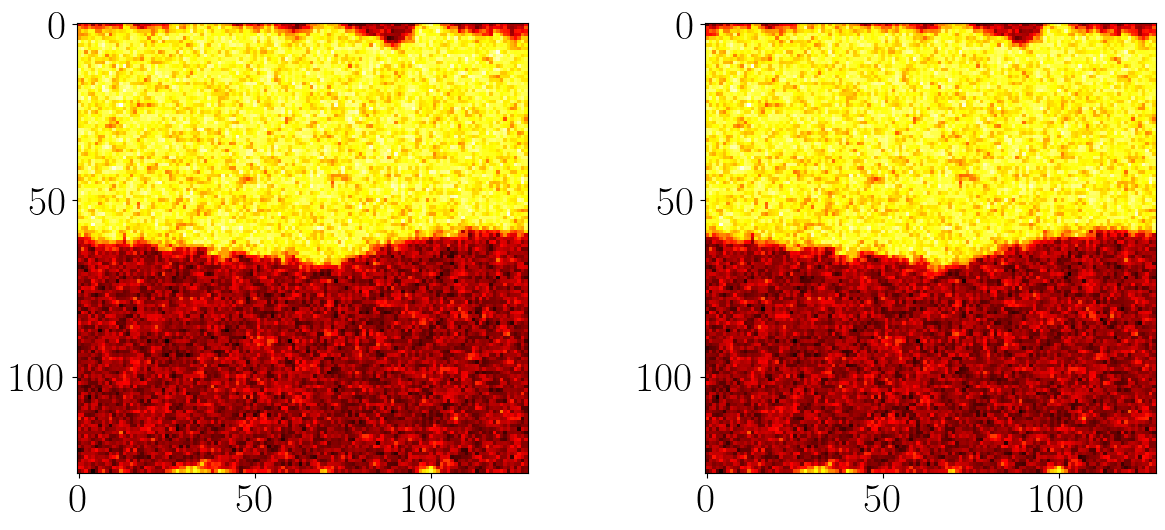

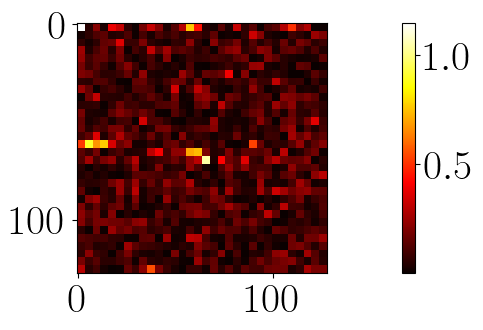

In [56]:
import phi4_mg as phimg
rg = phimg.RGlayer("average",batch_size=batch_size)
import integrators as i

sg2 = phi4_c1(sg,rg)
mn2_2 = i.minnorm2(sg2.force,sg2.evolveQ,7,1.0)
hmc_2 = u.hmc(T=sg2,I=mn2_2,verbose=False)
Nlevels=2
sg2.generate_cfg_levels(phi,Nlevels)
phi2=sg2.phis[-1]

fig, ax = plt.subplots(1,2, figsize=(18,6))
ax[0].imshow(phi[0,:,:], cmap='hot', interpolation='nearest')
phinew = hmc_2.evolve(phi2,1)
#phinew = phi2
for sss in reversed(range(Nlevels)):
    print("refining level ",phinew.shape)
    phinew= rg.refine(phinew,sg2.pics[sss])

#phinew=hmc.evolve(phinew,1)
ax[1].imshow(phinew[0,:,:], cmap='hot', interpolation='nearest')
fig.savefig("phi_fine_coarse.svg", bbox_inches='tight',dpi=300)
print("reject rate: ",hmc_2.AcceptReject )
diff=(phi-phinew)
#plot diff
print(tr.tensor(hmc_2.AcceptReject).sum()/len(hmc_2.AcceptReject))
plt.figure(figsize=(16, 4))
plt.imshow(tr.abs(diff[0,:,:]).detach(), cmap='hot', interpolation='nearest')
plt.colorbar()

In [83]:
#still need to change the code of phi_coarse try Vcycle instead
def V_cycle(phi_o,sgc_c,rg_c,hmc_f,m1,m2,Nlevels,Nskip=1):
    phi_o= hmc_f.evolve(phi_o,m1)
    sgc = phi4_c1(sgc_c,rg_c)
    mn2c = i.minnorm2(sgc.force,sgc.evolveQ,7,1.0)
    hmcc = u.hmc(T=sgc,I=mn2c,verbose=False)
    sgc.generate_cfg_levels(phi_o,Nlevels)
    phic=sgc.phis[-1]
    phic_up=hmcc.evolve(phic,Nskip)
    #now go back up
    for sss in reversed(range(Nlevels)):
        phic_up= rg_c.refine(phic_up,sgc.pics[sss])

    #print("shape of fine field ",phic_up.shape)
    phic_up=hmc_f.evolve(phic_up,m2)
    return phic_up, hmcc.AcceptReject

In [103]:
def get_observables_MCMG(sg,rg, hmc, phi, Nwarm, Nmeas, Lev):

    tic=time.perf_counter()
    Vol=sg.Vol
    lat=[phi.shape[1], phi.shape[2]]
    toc=time.perf_counter()

    print(f"time {(toc - tic)*1.0e6/Nwarm:0.4f} micro-seconds per HMC trajecrory")

    lC2p = []
    lchi_m = []
    E = []
    av_phi = []
    phase=tr.tensor(np.exp(1j*np.indices(tuple(lat))[0]*2*np.pi/lat[0]))
    for k in range(Nmeas):
        ttE = sg.action(phi)/Vol
        E.extend(ttE)
        av_sigma = tr.mean(phi.view(sg.Bs,Vol),axis=1)
        av_phi.extend(av_sigma)
        chi_m = av_sigma*av_sigma*Vol
        p1_av_sig = tr.mean(phi.view(sg.Bs,Vol)*phase.view(1,Vol),axis=1)
        C2p = tr.real(tr.conj(p1_av_sig)*p1_av_sig)*Vol
        if(k%10==0):
            print("k= ",k,"(av_phi,chi_m, c2p, E) ", av_sigma.mean().detach().numpy(),chi_m.mean().detach().numpy(),C2p.mean().detach().numpy(),ttE.mean().detach().numpy())
        lC2p.extend(C2p)
        lchi_m.extend(chi_m)
        ## HMC update but also V cycle
        phi,accept=V_cycle(phi,sg,rg,hmc,1,1,Lev)

    return lC2p, lchi_m, E, av_phi, phi


mass_grid2=np.linspace(-.585,-0.54,11)
tau_phi2=np.zeros_like(mass_grid2)
tau_suscept2=np.zeros_like(mass_grid2)
sss=0
for mas in mass_grid2:
    L=128
    lat = [L,L]
    # This set of params is very very close to critical.
    lam = 2.4
    #
    Nwarm = 500
    Nmeas = 2000
    Nskip = 1
    batch_size = 1

    Vol = np.prod(lat)
    sg = s.phi4(lat,lam,mas,batch_size=batch_size,device=device)
    phi = sg.hotStart()
    mn2 = i.minnorm2(sg.force,sg.evolveQ,7,1.0)
    print(phi.shape,Vol,tr.mean(phi),tr.std(phi))
    hmc = u.hmc(T=sg,I=mn2,verbose=False)
    rg = phimg.RGlayer("average",batch_size=batch_size)
    

    lC2p, lchi_m, E, av_phi, phi = get_observables_MCMG(sg,rg, hmc, phi, Nwarm, Nmeas, Lev=1)
    tau_phi2[sss],tau_suscept2[sss] = get_autocorrelationtime(av_phi, lchi_m)
    sss+=1
    m_phi, e_phi,m_chi_m, e_chi_m,m_C2p, e_C2p,avE,eE,xi,m_xi,e_xi,phi=get_observables(lC2p, lchi_m, E, av_phi, phi)

torch.Size([1, 128, 128]) 16384 tensor(-0.0032) tensor(1.0018)
time 0.0023 micro-seconds per HMC trajecrory
k=  0 (av_phi,chi_m, c2p, E)  -0.0032258078 0.17048922 0.629420378731861 2.023998
k=  10 (av_phi,chi_m, c2p, E)  0.023427146 8.992049 2.676577858081663 1.898199
k=  20 (av_phi,chi_m, c2p, E)  -0.002848897 0.13297604 2.0787920151491286 1.8624964
k=  30 (av_phi,chi_m, c2p, E)  -0.019003581 5.916854 2.241590705768122 0.5237516
k=  40 (av_phi,chi_m, c2p, E)  -0.016558262 4.4921002 45.35241326075118 0.40337124
k=  50 (av_phi,chi_m, c2p, E)  -0.06389122 66.88092 52.54713589777176 0.3873845
k=  60 (av_phi,chi_m, c2p, E)  -0.079246655 102.89205 27.192346002869 0.38770574
k=  70 (av_phi,chi_m, c2p, E)  -0.131858 284.86096 51.05580503763221 0.38236958
k=  80 (av_phi,chi_m, c2p, E)  -0.09746921 155.65205 26.045893811672983 0.38431147
k=  90 (av_phi,chi_m, c2p, E)  -0.15953973 417.02072 149.9488123013329 0.381905
k=  100 (av_phi,chi_m, c2p, E)  -0.18212704 543.46155 158.51828412125252 0.3912

KeyboardInterrupt: 

In [106]:
mass_grid3=np.linspace(-.585,-0.54,11)
tau_phi3=np.zeros_like(mass_grid3)
tau_suscept3=np.zeros_like(mass_grid3)
sss=0
for mas in mass_grid:
    L=32
    lat = [L,L]
    # This set of params is very very close to critical.
    lam = 2.4
    #
    Nwarm = 500
    Nmeas = 2000
    Nskip = 1
    batch_size = 1

    Vol = np.prod(lat)
    sg = s.phi4(lat,lam,mas,batch_size=batch_size,device=device)
    phi = sg.hotStart()
    mn2 = i.minnorm2(sg.force,sg.evolveQ,7,1.0)
    print(phi.shape,Vol,tr.mean(phi),tr.std(phi))
    hmc = u.hmc(T=sg,I=mn2,verbose=False)
    rg = NonLinearRGlayer(channels=1, hidden_channels=1, batch_size=batch_size)
    

    lC2p, lchi_m, E, av_phi, phi = get_observables_MCMG(sg,rg, hmc, phi, Nwarm, Nmeas, Lev=1)
    tau_phi3[sss],tau_suscept3[sss] = get_autocorrelationtime(av_phi, lchi_m)
    sss+=1
    m_phi, e_phi,m_chi_m, e_chi_m,m_C2p, e_C2p,avE,eE,xi,m_xi,e_xi,phi=get_observables(lC2p, lchi_m, E, av_phi, phi)

torch.Size([1, 32, 32]) 1024 tensor(0.0442) tensor(1.0202)
time 0.0023 micro-seconds per HMC trajecrory
k=  0 (av_phi,chi_m, c2p, E)  0.044166483 1.9974945 2.107675942629816 2.097301
k=  10 (av_phi,chi_m, c2p, E)  -0.1411353 20.397234 17.67586133269368 0.38962618
k=  20 (av_phi,chi_m, c2p, E)  -0.28121033 80.97715 0.611510916163829 0.40231615
k=  30 (av_phi,chi_m, c2p, E)  -0.4200345 180.66327 7.568677437422962 0.39111614
k=  40 (av_phi,chi_m, c2p, E)  -0.5406639 299.33307 5.649982405814359 0.392425
k=  50 (av_phi,chi_m, c2p, E)  -0.6594535 445.31604 1.0577055075179291 0.35927868
k=  60 (av_phi,chi_m, c2p, E)  -0.70698917 511.82968 1.2732701426670736 0.34719497
k=  70 (av_phi,chi_m, c2p, E)  -0.54171735 300.50067 2.7493084961948715 0.39092046
k=  80 (av_phi,chi_m, c2p, E)  -0.71133643 518.1435 1.7485856692145239 0.34657347
k=  90 (av_phi,chi_m, c2p, E)  -0.7548738 583.5105 6.272993378531469 0.3313948
k=  100 (av_phi,chi_m, c2p, E)  -0.70756996 512.67096 1.0247837796589903 0.3012231
k= 

KeyboardInterrupt: 

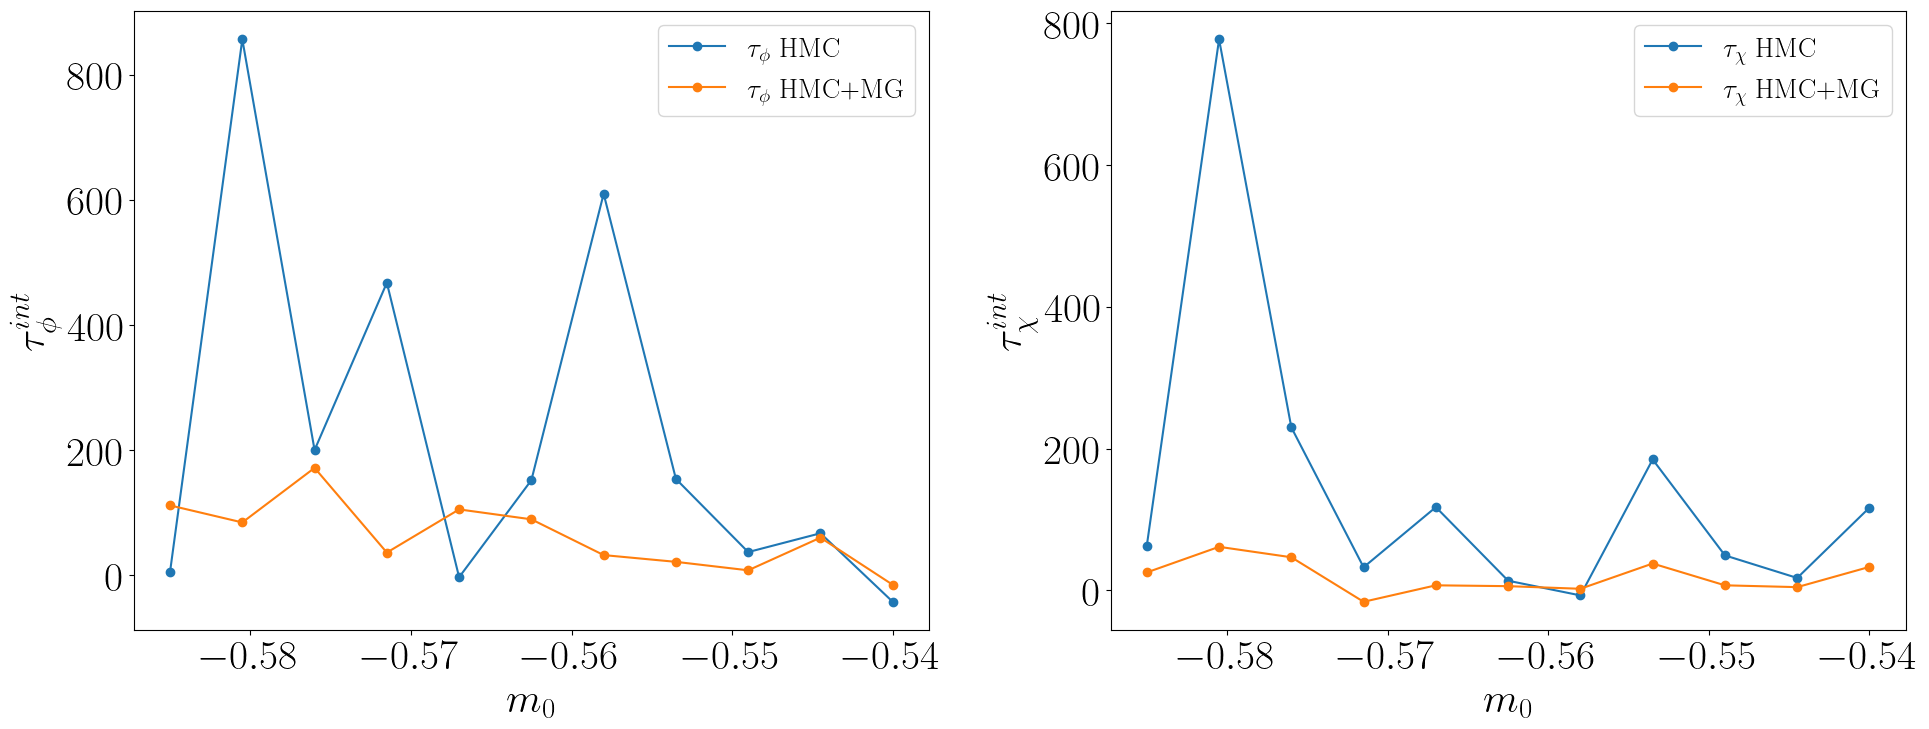

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(20, 8))
ax[0].plot(mass_grid1,tau_phi1,'o-',label=r'HMC')
ax[0].plot(mass_grid2,tau_phi2,'o-',label=r'HMC+MG')
#ax[0].plot(mass_grid3,tau_phi3,'o-',label=r'$\tau_{\phi}$ HMC+MG+CNN')
ax[0].set_xlabel(r'$m_0$', fontsize=30)
ax[0].set_ylabel(r'$\tau_{\phi}^{int}$', fontsize=30)
ax[0].legend(fontsize=20)
ax[1].plot(mass_grid1,tau_suscept1,'o-',label=r'HMC')
ax[1].plot(mass_grid2,tau_suscept2,'o-',label=r'HMC+MG')
#ax[1].plot(mass_grid3,tau_suscept3,'o-',label=r'$\tau_{\chi}$ HMC+MG+CNN')
ax[1].set_xlabel(r'$m_0$', fontsize=30)
ax[1].set_ylabel(r'$\tau_{\chi}^{int}$', fontsize=30)
ax[1].legend(fontsize=20)

shape of the original field torch.Size([1, 64, 64])
coarsening level  0  field shape  torch.Size([1, 64, 64])
shape of fine field  torch.Size([1, 64, 64])
shape of new field  torch.Size([1, 64, 64])
reject rate:  [1.0]
tensor(1.)


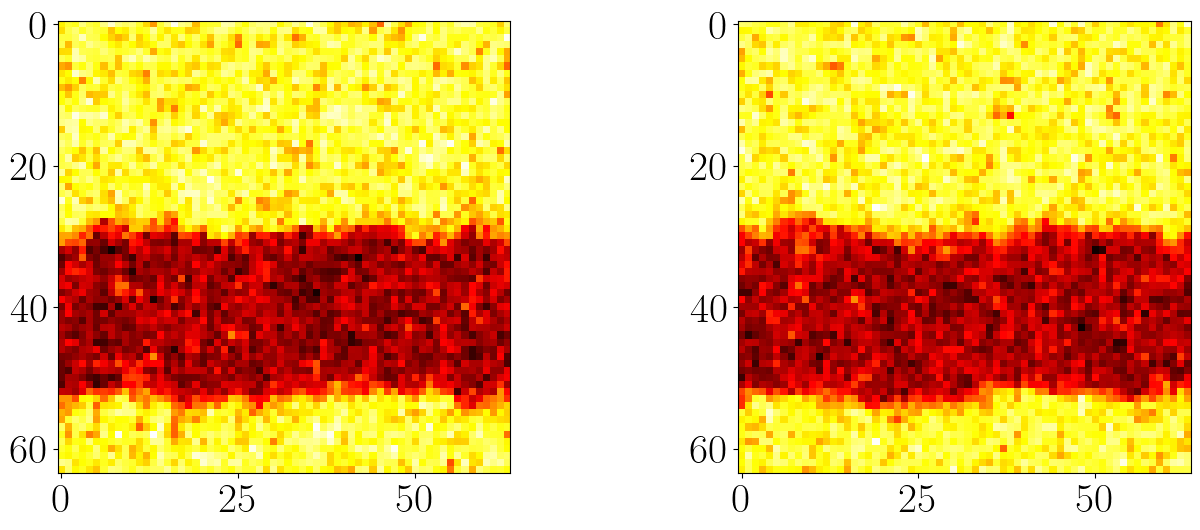

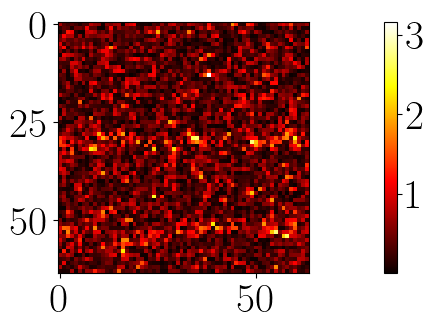

In [ ]:

fig, ax = plt.subplots(1,2, figsize=(18,6))
ax[0].imshow(phi[0,:,:], cmap='hot', interpolation='nearest')
phi_new,accept=V_cycle(phi,sg,rg,hmc,1,1,Nlevels=1)
print("shape of new field ",phi_new.shape)
ax[1].imshow(phi_new[0,:,:], cmap='hot', interpolation='nearest')
print("reject rate: ",accept )
diff=(phi-phi_new)
#plot diff
print(tr.tensor(accept).sum()/len(accept))
plt.figure(figsize=(16, 4))
plt.imshow(tr.abs(diff[0,:,:]).detach(), cmap='hot', interpolation='nearest')
plt.colorbar()


In [ ]:
#still need to change the code of phi_coarse try Vcycle instead
def Wcycle(phi,sg,rg,hmc_f,m1,m2,Nlevels=2,Nskip=1):

    sgc = phi4_c1(sg,rg)
    mn2c = i.minnorm2(sgc.force,sgc.evolveQ,7,1.0)
    hmcc = u.hmc(T=sgc,I=mn2c,verbose=False)
    sgc.generate_cfg_levels(phi,Nlevels)
    phic=sgc.phis[-1]
    phic_up=hmcc.evolve(phic,Nskip)
    #now go back up
    for sss in reversed(range(Nlevels-1)):
        phic_up= rg.refine(phic_up,sgc.pics[sss])
    
    phic_up=hmc_f.evolve(phic_up,m1)
    return phic_up, hmcc.AcceptReject

256

In [56]:
phi_c = sg2.phis[-1]
phi_c.requires_grad_()
S = sg2.action(phi_c)
print("action", S)
grad = tr.autograd.grad(S.sum(), phi_c, retain_graph=True)[0]
print("grad ok? nan:", tr.isnan(grad).any(), "shape:", grad.shape)

action tensor([6299.9238], grad_fn=<SubBackward0>)
grad ok? nan: tensor(False) shape: torch.Size([1, 64, 64])


shape of the original field torch.Size([1, 64, 64])
coarsening level  0  field shape  torch.Size([1, 64, 64])
coarsening level  1  field shape  torch.Size([1, 32, 32])
coarsening level  2  field shape  torch.Size([1, 16, 16])
torch.Size([1, 8, 8])
reject rate:  [1.0]
tensor(1.)


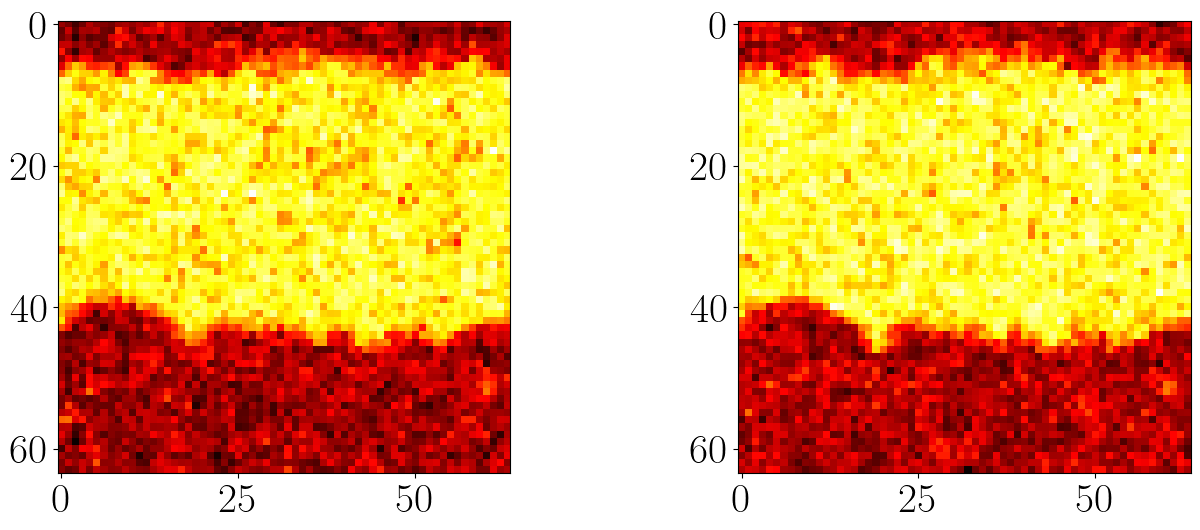

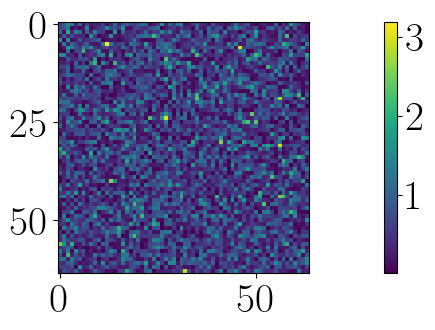

In [ ]:
import phi4_mg as phimg
#rg = NonLinearRGlayer("average",batch_size=batch_size)

rg = NonLinearRGlayer(channels=1, hidden_channels=1, batch_size=batch_size)
import integrators as i

sg2 = phi4_c1(sg,rg)
mn2_2 = i.minnorm2(sg2.force,sg2.evolveQ,7,1.0)
hmc_2 = u.hmc(T=sg2,I=mn2_2,verbose=False)
Nlevels=3
sg2.generate_cfg_levels(phi,Nlevels)
phi2=sg2.phis[-1]

fig, ax = plt.subplots(1,2, figsize=(18,6))
ax[0].imshow(phi[0,:,:], cmap='hot', interpolation='nearest')
print(phi2.shape)
#remove gradient
#phi2 = phi2.detach()
#ax[1].imshow(phi2[0,:,:].detach(), cmap='hot', interpolation='nearest')

phinew = hmc_2.evolve(phi2,1)

for sss in reversed(range(Nlevels)):
    phinew= rg.refine(phinew,sg2.pics[sss])

phinew=hmc.evolve(phinew,10)
ax[1].imshow(phinew[0,:,:].detach(), cmap='hot', interpolation='nearest')
print("reject rate: ",hmc_2.AcceptReject )
diff=(phi-phinew)
#plot diff
print(tr.tensor(hmc_2.AcceptReject).sum()/len(hmc_2.AcceptReject))
plt.figure(figsize=(16, 4))
plt.imshow(tr.abs(diff[0,:,:]).detach(), interpolation='nearest')
plt.colorbar()

 MG flow works but I have to figure out the coarsening procedure

In [24]:
normal = distributions.Normal(tr.zeros(Vol),tr.ones(Vol))
prior= distributions.Independent(normal, 1)

mg = phimg.MGflow([L,L],phimg.FlowBijector,phimg.RGlayer("average",batch_size==2),prior)
#print("The MG module: ",mg)
x = mg(phi)
#print(x)
z,J = mg.backward(x)

print("Test reversibility (must be zero): ",(z-phi).abs().mean().detach().numpy())

z = mg.sample(batch_size)
print(z.shape,x.shape)
J = mg.log_prob(x)
print("the logprobs are: ",J.detach().numpy())

def jwrap(x):
    z,_=mg.backward(x)
    return z

torchJacM = tr.autograd.functional.jacobian(jwrap,x)
print("Autograd jacobian matrix shape:",torchJacM.shape)
torchJacM = torchJacM.reshape(batch_size,Vol,batch_size,Vol)
print("Autograd jacobian matrix reshaped:",torchJacM.shape)
log_dets = []
diffs = []
for k in range(1):
    foo = torchJacM[k,:,k,:].squeeze()
    ldet  = np.log(foo.det().numpy())
    log_dets.append(ldet)
    diffs.append(np.abs(ldet - J[k].detach().numpy())/Vol)

print("log(Jacobians): ",log_dets)
print("Differences   : ",diffs)
    

Initializing MGflow module with size:  32
Using depth:  5
Using rg type:  average
(depth, size):  0 [32, 32]
(depth, size):  1 [16, 16]
(depth, size):  2 [8, 8]
(depth, size):  3 [4, 4]
(depth, size):  4 [2, 2]
Test reversibility (must be zero):  2.6313965e-06
torch.Size([2, 32, 32]) torch.Size([2, 32, 32])
the logprobs are:  [-6511.4326 -6283.6553]
Autograd jacobian matrix shape: torch.Size([2, 32, 32, 2, 32, 32])
Autograd jacobian matrix reshaped: torch.Size([2, 1024, 2, 1024])
log(Jacobians):  [62.896713]
Differences   :  [6.420243263244629]


In [26]:
Vol=np.prod(lat)
[phi.shape[1], phi.shape[2]],lat

([256, 256], [256, 256])

In [ ]:
lC2p_c = []
lchi_m_c = []
E_c = []
av_phi_c = []
lat_c=[phinew.shape[1],phinew.shape[2]]
Vol_c = np.prod(lat_c)
phase_c=tr.tensor(np.exp(1j*np.indices(tuple(lat_c))[0]*2*np.pi/lat_c[0]))
phi=sg.hotStart()
mn2 = i.minnorm2(sg.force,sg.evolveQ,7,1.0)
hmc = u.hmc(T=sg,I=mn2,verbose=False)
for k in range(Nmeas):
    ttE = sg.action(phi)/Vol
    E.extend(ttE)
    av_sigma = tr.mean(phi.view(sg.Bs,Vol),axis=1)
    av_phi.extend(av_sigma)
    chi_m = av_sigma*av_sigma*Vol
    p1_av_sig = tr.mean(phi.view(sg.Bs,Vol)*phase.view(1,Vol),axis=1)
    C2p = tr.real(tr.conj(p1_av_sig)*p1_av_sig)*Vol
    if(k%10==0):
        print("k= ",k,"(av_phi,chi_m, c2p, E) ", av_sigma.mean().numpy(),chi_m.mean().numpy(),C2p.mean().numpy(),ttE.mean().numpy())
    lC2p.extend(C2p)
    lchi_m.extend(chi_m)


    phi = hmc.evolve(phi,Nskip)

In [ ]:
phinew=hmc.evolve(phinew,10)

torch.Size([5, 128, 128]) 16384 tensor(0.0773) tensor(3.6547)


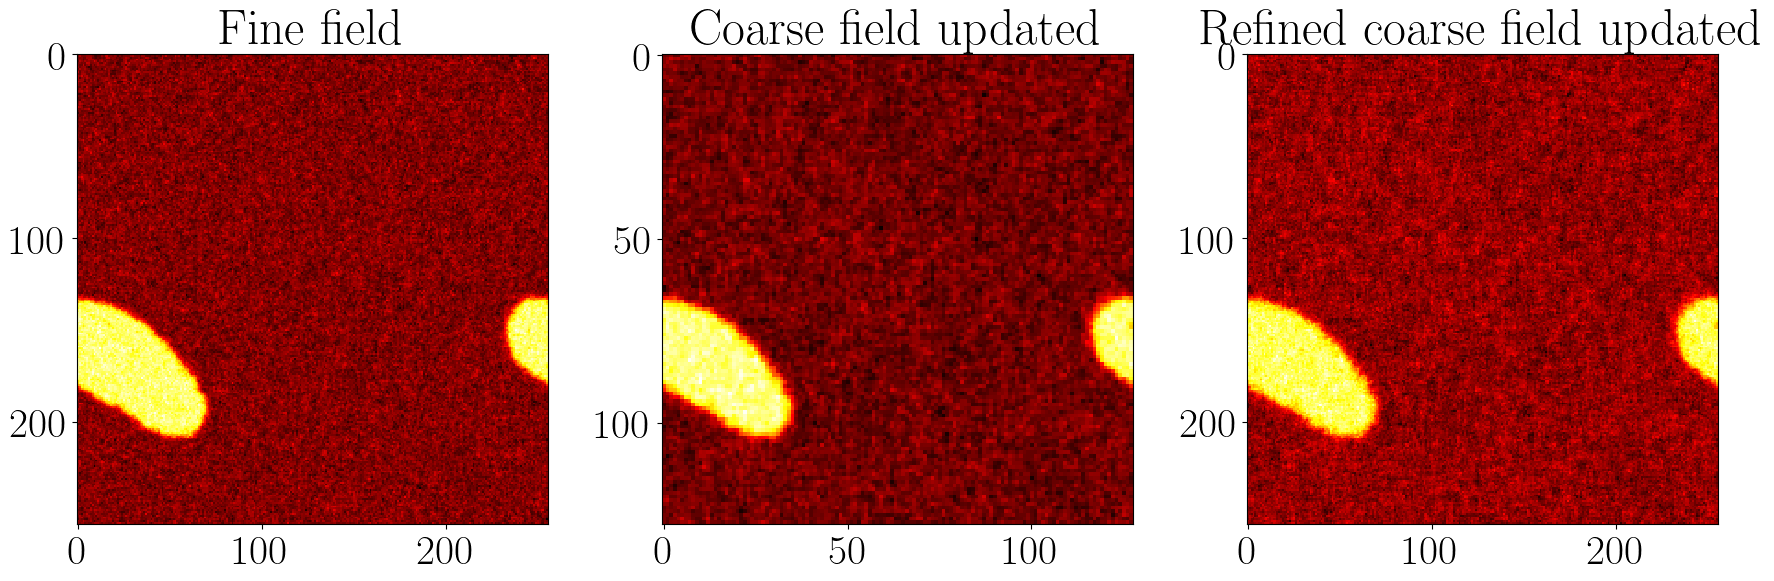

In [ ]:
#define the new lattice and simulate there but starting with the field phi2
L2 = L//2
lat2 = [L2,L2]
sg2 = s.phi4(lat2,lam,mas,batch_size=batch_size,device=device)
#phi2 = sg2.hotStart()
mn2_2 = i.minnorm2(sg2.force,sg2.evolveQ,7,1.0)
phi2 = phi2
print(phi2.shape,Vol//4,tr.mean(phi2),tr.std(phi2))

#mn2 = i.minnorm2(sg.force,sg.evolveQ,7,1.0)
#print(phi.shape,Vol,tr.mean(phi),tr.std(phi))
hmc_2 = u.hmc(T=sg2,I=mn2_2,verbose=False)
phi2 = hmc_2.evolve(phi2,1)

# If we want to come back to the fine lattice
rphi = rg.refine(phi2,pi)
rphi.shape
fig, ax= plt.subplots(1,3, figsize=(18,6))
ax[0].imshow(phi[0,:,:], cmap='hot', interpolation='nearest')
ax[0].set_title(f"Fine field")
ax[1].imshow(phi2[0,:,:], cmap='hot', interpolation='nearest')
ax[1].set_title(f"Coarse field updated")
ax[2].imshow(rphi[0,:,:], cmap='hot', interpolation='nearest')
ax[2].set_title(f"Refined coarse field updated")
plt.show()



This is a naive example of updating but with the wrong distribution. Fortunatelly, this is a linear transformation and the jacobian is 1 from $\psi, \pi \rightarrow \phi$